In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from skopt.plots import expected_minimum
from skopt import gp_minimize

import sys
sys.path.insert(0, "../func_py/")
import data_utils as dt
import my_utils as mut
import infer_memplasm as mp

In [2]:
metadata = pd.read_csv('metadata/metadata.tsv', sep='\t', index_col=0)

### Importing the data
Each of the two cells below imports one of the two pateients

In [ ]:
pat = '1'
mem_samp = ['pat1_t1_mc', '', 'pat1_t2_mc']
pb_samp = ['', 'pat1_t2_pc', 'pat1_t3_pc']
sp_counts, pars = mp.import_data(mem_samp, pb_samp)
dtimes, dts = [49/6, 11/6], [0.1, 0.01]
file_name = 'pat1_nmin1_exe'
gbm_pars = dt.read_pars('inference/gbm/' + file_name + '.txt')

In [3]:
pat = '2'
mem_samp = ['pat2_t1_mc', 'pat2_t2_mc', 'pat2_t3_mc', '']
pb_samp = ['', 'pat2_t2_pc', 'pat2_t3_pc', 'pat2_t4_pc']
sp_counts, pars = mp.import_data(mem_samp, pb_samp)
dtimes, dts = [6, 1/6, 1/3], [0.1, 0.01, 0.01]
file_name = 'pat2_3_nmin1_exe'
gbm_pars = dt.read_pars('inference/gbm/' + file_name + '.txt')

### Finding best priors

The exploration is the same of the Geometric Brownian Motion: we vary two parameters of the gamma distribution used as a prior importance function for the first time point of memory cells.

In [ ]:
mp_pars = mp.mp_infer_pars(
    dtimes=dtimes, sample_indexes=[pars['m_ids'], pars['p_ids']],
    tau_m=gbm_pars['tau'], theta_m=gbm_pars['theta'], Mm_tot=gbm_pars['M_tot'], n0=gbm_pars['n0'],
    m_der_f=0.5, p_to_m=0.1, # Parameters f and r of the paper
    n_eval=20000, 
    prior_pars=[0,0], dts=dts
)


gamma_as = [2, 4, 8]
std_factors = np.logspace(-0.25, 1, 10)
R = 30

stds = np.zeros((len(gamma_as), len(std_factors)))
avs = np.zeros((len(gamma_as), len(std_factors)))
for i, a in enumerate(gamma_as):
    for j, f in enumerate(std_factors):
        mp_pars.prior_pars = [a, f]
        vals = [mp.log_like_MC(sp_counts, 1, 0.1, mp_pars)[0] for _ in range(R)]
        stds[i,j] = np.std(vals) / np.mean(vals)
        avs[i,j] = np.mean(vals)
        print(i, j)

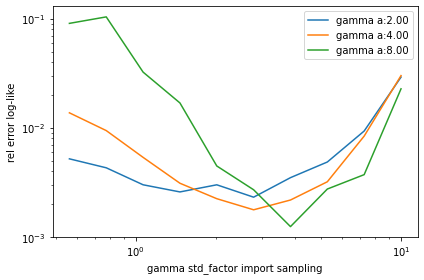

In [30]:
plt.xscale('log')
plt.yscale('log')
plt.xlabel('gamma std_factor import sampling')
plt.ylabel('rel error log-like')
for i, a in enumerate(gamma_as):
    plt.plot(std_factors, np.abs(stds[i]/avs[i]), label='gamma a:%3.2f'%a)
plt.legend()
plt.tight_layout()
#plt.savefig('plots/memplasm_infer/rel_error_pat'+pat+'_nmin_'+str(mp_pars.n1_min)+'.svg', dpi=200, facecolor='w')

### Visualizing the likelihood

In [6]:
mp_pars.m_der_f = 0.5
mp_pars.p_to_m = 0.01
mp_pars.n_eval = 1 * 10**5
name = 'll_scan_pat'+pat+'_mder'+str(mp_pars.m_der_f)+'_ptom'+str(mp_pars.p_to_m)+'.svg'

In [ ]:
taus = np.logspace(np.log10(0.01), np.log10(10), 15)
alphas = np.logspace(np.log10(0.1), np.log10(1), 15)
lls = np.zeros((len(taus), len(alphas)))
progress = tqdm(total=len(taus)*len(alphas))
for i, t in enumerate(taus):
    for j, a in enumerate(alphas):
        th = a * t / 2
        for k in range(len(mp_pars.dts)-1):
            mp_pars.dts[k+1] = min(0.01, min(t, th) / 5)
        ll, fr = mp.log_like_MC(sp_counts, t, th, mp_pars)
        lls[i,j] = ll
        progress.update(1)
        lts = "%3.2f"%np.log10(t)
        astr = "%3.2f"%a
        print(lts, astr, lls[i,j])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

vmax = np.max(lls)
ax = mp.plot_heatmap(ax, lls, alphas, np.log10(taus), vmax-0.1, vmax, labx='alpha', laby='log10 tau', cb=True)
    
plt.tight_layout()
name = 'pat'+pat+'_mder'+str(mp_pars.m_der_f)+'_ptom'+str(mp_pars.p_to_m)
#plt.savefig('plots/memplasm_infer/ll_scan_'+name+'.svg', facecolor='w')

### Finding maximum with GP

In [32]:
mp_pars.m_der_f = 0.3
mp_pars.p_to_m = 0.02
mp_pars.n_eval = 3 * 10**5
name = 'll_scan_pat'+pat+'_mder'+str(mp_pars.m_der_f)+'_ptom'+str(mp_pars.p_to_m)+'.svg'

In [33]:
def ll_func(x):
    tau, alpha = 10**x[0], 10**x[1]
    theta = alpha*tau / 2.0
    for k in range(len(mp_pars.dts)-1):
        mp_pars.dts[k+1] = min(0.01, min(tau, theta) / 5)
    return -mp.log_like_MC(sp_counts, tau, theta, mp_pars)[0]

def cb(res):
    if len(res.models) > 0:
        print(len(res.x_iters), expected_minimum(res)[0], flush=True, end='\r')
    else:
        print(len(res.x_iters), flush=True, end='\r')
    
n_calls = 50
bounds = [(-1.6, 1), (-1., 0)]
%time res = gp_minimize(ll_func, dimensions=bounds, callback=cb, n_calls=n_calls)

CPU times: user 11min 28s, sys: 2min 6s, total: 13min 35s
Wall time: 11min 11s


In [35]:
x_min = expected_minimum(res)[0]
x = np.linspace(bounds[1][0], bounds[1][1], 100)
y = np.linspace(bounds[0][0], bounds[0][1], 100)
z = np.zeros((len(y), len(x)))
for i in range(len(y)):
    for j in range(len(x)):
        z[i,j] = mut.gp_mean(np.array([y[j], x[i]]), res)
        
N = len(sp_counts[sp_counts['counts_m1'] >= mp_pars.n1_min])
H = mut.hess(lambda x : N*mut.gp_mean(x, res), np.array(x_min), 0.01)
H_inv = np.linalg.inv(H)
errs = np.sqrt([H_inv[0,0], H_inv[1,1]])

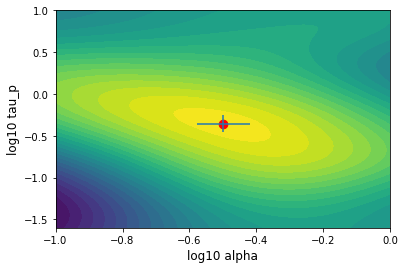

In [36]:
plt.xlabel('log10 alpha', fontsize=12)
plt.ylabel('log10 tau_p', fontsize=12)

plt.contourf(x, y, -z.T, levels=25)
plt.errorbar([x_min[1]],[x_min[0]], xerr=[errs[1]], yerr=[errs[0]])
plt.scatter([x_min[1]],[x_min[0]], c='r', s=75)
plt.savefig('plots/memplasm_infer/gp_'+name+'.svg', facecolor='w')

In [26]:
theta = 10**x_min[0] * 10**x_min[1] / 2.0
err_theta = mut.error_prod(np.log10(theta), x_min[0], x_min[1], errs[0], errs[1], H_inv[0,1])

f = open('inference/memplasm/result_'+name+'.txt', 'w')
f.write('log10_tau_p:\t'+str(x_min[0])+'\n')
f.write('log10_alpha:\t'+str(x_min[1])+'\n')
f.write('log10_theta:\t'+str(np.log10(theta))+'\n')
f.write('tau_p:\t'+str(10**x_min[0])+'\n')
f.write('alpha:\t'+str(10**x_min[1])+'\n')
f.write('theta:\t'+str(theta)+'\n')
f.write('log10_tau_p_err:\t'+str(errs[0])+'\n')
f.write('log10_alpha_err:\t'+str(errs[1])+'\n')
f.write('log10_theta_err:\t'+str(err_theta)+'\n')

f.close()

### Parameter scan

In [10]:
def ll_func(x, mp_pars):
    tau, alpha = 10**x[0], 10**x[1]
    theta = alpha*tau / 2.0
    for k in range(len(mp_pars.dts)-1):
        mp_pars.dts[k+1] = min(0.01, min(tau, theta) / 5)
    return -mp.log_like_MC(sp_counts, tau, theta, mp_pars)[0]


def find_max_ll(mp_pars, bounds, n_calls):
    res = gp_minimize(lambda x : ll_func(x, mp_pars), dimensions=bounds, n_calls=n_calls)
    x_min, ll = expected_minimum(res)[0], -expected_minimum(res)[1]
    N = len(sp_counts[sp_counts['counts_m1'] >= mp_pars.n1_min])
    H = mut.hess(lambda x : N*mut.gp_mean(x, res), np.array(x_min), 0.01)
    H_inv = np.linalg.inv(H)
    errs = np.sqrt([H_inv[0,0], H_inv[1,1]])
    return x_min, ll, errs, H_inv[0,1]

In [ ]:
m_der_fs = [0.3, 0.5, 0.8]
p_to_ms = [0.01, 0.02, 0.05, 0.1]
result_fr = pd.DataFrame(columns=['m_der_f', 'p_to_m', 'll', 'log10_tau_p', 'log10_theta_p', 'err_tau_p', 'err_theta_p'])
n_calls = 50
mp_pars.n_eval = 3 * 10**5

for m_der_f in m_der_fs:
    for p_to_m in p_to_ms:
        aux_d = {'m_der_f' : m_der_f, 'p_to_m' : p_to_m}
        mp_pars.m_der_f = m_der_f
        mp_pars.p_to_m = p_to_m
        x_min, ll, errs, cov = find_max_ll(mp_pars, [(-1.6, 1), (-1.3, 0)], n_calls)
        theta = 10**x_min[0] * 10**x_min[1] / 2.0
        err_theta = mut.error_prod(np.abs(np.log10(theta)), x_min[0], x_min[1], errs[0], errs[1], cov)
        aux_d['ll'] = ll
        aux_d['log10_tau_p'] = x_min[0]
        aux_d['theta_p'] = theta
        aux_d['err_tau_p'] = errs[0]
        aux_d['err_theta_p'] = err_theta
        result_fr.loc[len(result_fr)] = aux_d
        print(aux_d)

In [80]:
result_fr.to_csv('inference/memplasm/result_pat'+pat+'.csv')

In [14]:
pat = '2'
result_fr = pd.read_csv('inference/memplasm/result_pat'+pat+'.csv', index_col=0)
result_fr

,m_der_f,p_to_m,ll,log10_tau_p,log10_theta_p,err_tau_p,err_theta_p
0,0.3,0.01,-5.913516,-0.495998,-1.237769,0.082355,0.199099
1,0.3,0.02,-5.912957,-0.536449,-1.245090,0.079944,0.189431
2,0.3,0.05,-5.913016,-0.439581,-1.243255,0.081958,0.208931
3,0.3,0.10,-5.912621,-0.498726,-1.247324,0.070664,0.164341
4,0.5,0.01,-5.905580,-0.244725,-1.116889,0.085568,0.329883
5,0.5,0.02,-5.904683,-0.406995,-1.221276,0.113801,0.242999
6,0.5,0.05,-5.904610,-0.311993,-1.141605,0.096469,0.277429
7,0.5,0.10,-5.904750,-0.488055,-1.197668,0.088668,0.208270
8,0.8,0.01,-5.902083,-0.057252,-1.076459,0.101160,1.838300
9,0.8,0.02,-5.902396,-0.060933,-1.138373,0.097890,1.775809


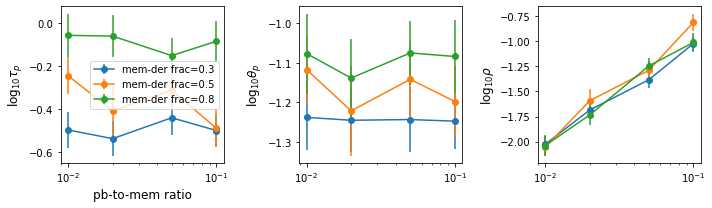

In [15]:
fig, axs = plt.subplots(1,3,figsize=(10,3))
axs[0].set_xlabel('pb-to-mem ratio', fontsize=12)
for ax in axs:
    ax.set_xscale('log')
axs[0].set_ylabel(r'$\log_{10} \tau_p$', fontsize=12)
axs[1].set_ylabel(r'$\log_{10} \theta_p$', fontsize=12)
axs[2].set_ylabel(r'$\log_{10} \rho$', fontsize=12)

m_der_fs = np.unique(result_fr['m_der_f'])
for i, m_der_f in enumerate(m_der_fs):
    sub_fr = result_fr[result_fr.m_der_f == m_der_f]
    axs[0].errorbar(sub_fr.p_to_m, sub_fr.log10_tau_p, yerr=sub_fr.err_tau_p, marker='o',  label='mem-der frac='+str(m_der_f))
    axs[1].errorbar(sub_fr.p_to_m, sub_fr.log10_theta_p, yerr=sub_fr.err_tau_p, marker='o')
    rhos = np.log10(sub_fr.p_to_m * sub_fr.m_der_f) - sub_fr.log10_tau_p
    axs[2].errorbar(sub_fr.p_to_m, rhos, yerr=sub_fr.err_tau_p, marker='o')
    
axs[0].legend()
plt.tight_layout()
#plt.savefig('plots/memplasm_infer/params_pat'+pat+'.svg')